## ML Midterm Project
Zhuoyang Zou

In [4]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load the Excel file
file_path = '/short_sentence.xlsx'
data = pd.read_excel(file_path)

print(data.head())

# Prepare the dataset
llm_columns = ['ChatGPT4o', 'Claude 3.5Sonnet', 'Llama 3.1 405B', 'Qwen2.5-72B']
data_long_format = pd.melt(data, id_vars=['Sentence'], value_vars=llm_columns, var_name='LLM', value_name='Expanded_Sentence')

# Define feature and target variables
X = data_long_format['Expanded_Sentence']
y = data_long_format['LLM']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose BERT to embedding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to generate embeddings using BERT
def generate_embeddings(text_list, tokenizer, model):
    embeddings = []
    for text in text_list:
        # Tokenize and get tensor input
        inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)

        if isinstance(model, BertModel):
            embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze().numpy())
    return embeddings

# Generate embeddings for training and testing datasets
X_train_embeddings = generate_embeddings(X_train.tolist(), tokenizer, model)
X_test_embeddings = generate_embeddings(X_test.tolist(), tokenizer, model)


                             Sentence  \
0            Cats give the dogs gifts   
1       Dogs wear hats on their heads   
2   Bananas are for the monkeys lunch   
3         Pizza flies across the room   
4  Giraffes play chess with the bears   

                                          ChatGPT4o  \
0      Cats give the dogs gifts on their birthdays.   
1  Dogs wear hats on their heads during the parade.   
2    Bananas are for the monkeys' lunch in the zoo.   
3      Pizza flies across the room in a food fight.   
4    Giraffes play chess with the bears at the zoo.   

                                    Claude 3.5Sonnet  \
0    Cats give the dogs gifts of catnip-filled toys.   
1  Dogs wear hats on their heads for the annual p...   
2  Bananas are for the monkeys' lunch at the zoo ...   
3  Pizza flies across the room during the food fi...   
4  Giraffes play chess with the bears in the whim...   

                                      Llama 3.1 405B  \
0  Cats give dogs gifts, care

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [5]:
# Train a Logistic Regression classifier using the embeddings
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test_embeddings)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)


Accuracy: 0.5769230769230769
Classification Report:
                   precision    recall  f1-score   support

       ChatGPT4o       0.71      0.49      0.58        65
Claude 3.5Sonnet       0.36      0.45      0.40        67
  Llama 3.1 405B       1.00      0.94      0.97        64
     Qwen2.5-72B       0.39      0.44      0.41        64

        accuracy                           0.58       260
       macro avg       0.62      0.58      0.59       260
    weighted avg       0.61      0.58      0.59       260



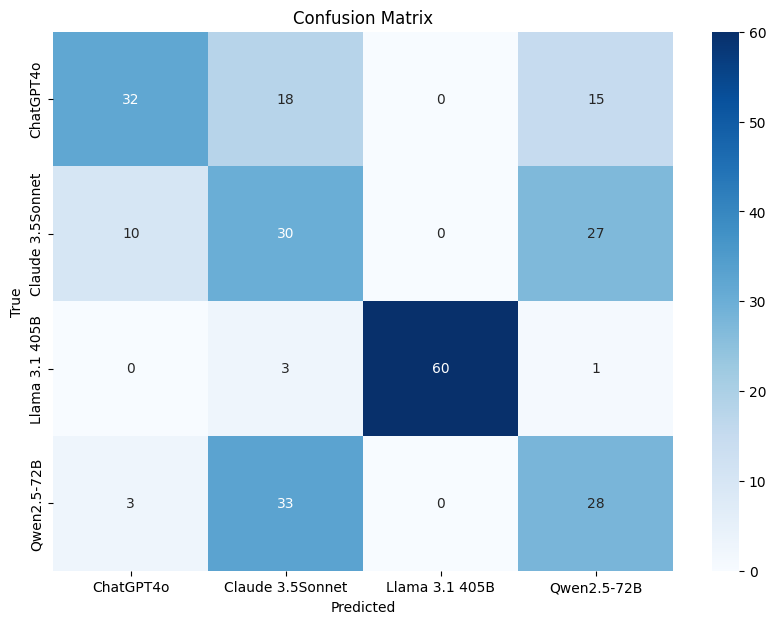

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=llm_columns)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=llm_columns, yticklabels=llm_columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

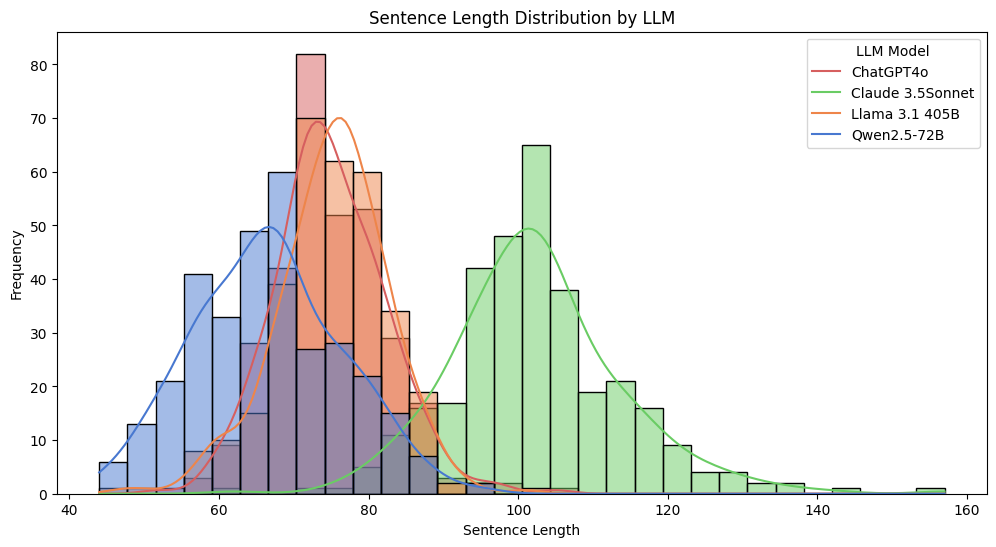

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel data
file_path = '/short_sentence.xlsx'
data = pd.read_excel(file_path)

# Prepare the dataset
llm_columns = ['ChatGPT4o', 'Claude 3.5Sonnet', 'Llama 3.1 405B', 'Qwen2.5-72B']
data_long_format = pd.melt(data, id_vars=['Sentence'], value_vars=llm_columns, var_name='LLM', value_name='Expanded_Sentence')

# Calculate the length of each sentence
data_long_format['Length'] = data_long_format['Expanded_Sentence'].apply(len)

# Plot the distribution of sentence lengths for each LLM
plt.figure(figsize=(12, 6))
sns.histplot(data=data_long_format, x='Length', hue='LLM', kde=True, bins=30, palette='muted')

# Custom legend with LLM names and color representation
plt.title('Sentence Length Distribution by LLM')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

# Display legend with better positioning and title
plt.legend(title='LLM Model', loc='upper right', labels=llm_columns)
plt.show()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-11-66d86ab92d76>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(embeddings)


Epoch [5/30], Loss: 1.2854
Epoch [10/30], Loss: 1.1135
Epoch [15/30], Loss: 0.9621
Epoch [20/30], Loss: 0.8516
Epoch [25/30], Loss: 0.7717
Epoch [30/30], Loss: 0.7113
Test Accuracy: 0.5962
Classification Report:
                   precision    recall  f1-score   support

       ChatGPT4o       0.61      0.55      0.58        65
Claude 3.5Sonnet       0.43      0.39      0.41        67
  Llama 3.1 405B       0.91      0.94      0.92        64
     Qwen2.5-72B       0.44      0.52      0.47        64

        accuracy                           0.60       260
       macro avg       0.60      0.60      0.60       260
    weighted avg       0.60      0.60      0.59       260



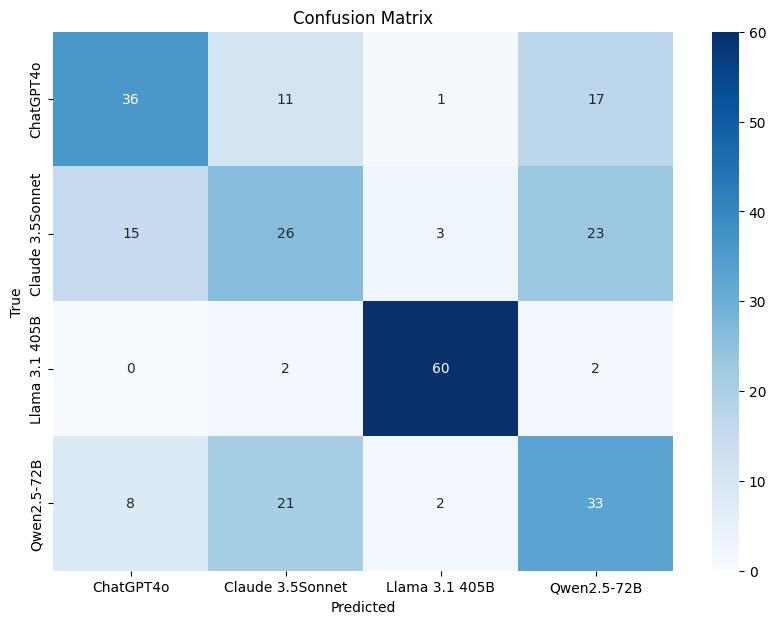

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel data
file_path = '/short_sentence.xlsx'  # Adjust the path if needed
data = pd.read_excel(file_path)

# Prepare the dataset
llm_columns = ['ChatGPT4o', 'Claude 3.5Sonnet', 'Llama 3.1 405B', 'Qwen2.5-72B']
data_long_format = pd.melt(data, id_vars=['Sentence'], value_vars=llm_columns, var_name='LLM', value_name='Expanded_Sentence')

# Define feature and target variables
X = data_long_format['Expanded_Sentence']
y = data_long_format['LLM']

# Encode the LLM labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Choose the model (using BERT in this example)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to generate embeddings using BERT
def generate_embeddings(text_list, tokenizer, model):
    embeddings = []
    for text in text_list:
        # Tokenize and get tensor input
        inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)

        # Use the [CLS] token embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)
    return torch.tensor(embeddings)

# Generate embeddings for training and testing datasets
X_train_embeddings = generate_embeddings(X_train.tolist(), tokenizer, model)
X_test_embeddings = generate_embeddings(X_test.tolist(), tokenizer, model)

# Define the RNN-based classification model
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = X_train_embeddings.shape[1]
hidden_size = 128
num_layers = 2
num_classes = len(label_encoder.classes_)

# Initialize the model, loss function, and optimizer
rnn_model = RNNClassifier(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Reshape embeddings to fit RNN input (batch_size, seq_length, input_size)
X_train_embeddings = X_train_embeddings.unsqueeze(1)
X_test_embeddings = X_test_embeddings.unsqueeze(1)

# Convert data to PyTorch tensors
X_train_tensor = X_train_embeddings.float()
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = X_test_embeddings.float()
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Training the model
num_epochs = 30
for epoch in range(num_epochs):
    rnn_model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = rnn_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
rnn_model.eval()
with torch.no_grad():
    # Predict on the test set
    outputs = rnn_model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

    # Calculate accuracy
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Test Accuracy: {accuracy:.4f}')

    # Generate classification report
    report = classification_report(y_test_tensor, predicted, target_names=label_encoder.classes_)
    print("Classification Report:\n", report)

    # Generate confusion matrix
    cm = confusion_matrix(y_test_tensor, predicted)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Merged DataFrame with Average Length and Classification Metrics:
                LLM  Sentence_Length  Precision  Recall  F1-Score  Support
0         ChatGPT4o        66.506173       0.61    0.55      0.58       65
1  Claude 3.5Sonnet        75.185185       0.43    0.39      0.41       67
2    Llama 3.1 405B       102.385802       0.91    0.94      0.92       64
3       Qwen2.5-72B        74.925926       0.44    0.52      0.47       64

Correlation Matrix:
                 Sentence_Length  Precision    Recall  F1-Score
Sentence_Length         1.000000   0.803000  0.873475  0.843356
Precision               0.803000   1.000000  0.962445  0.992708
Recall                  0.873475   0.962445  1.000000  0.988139
F1-Score                0.843356   0.992708  0.988139  1.000000


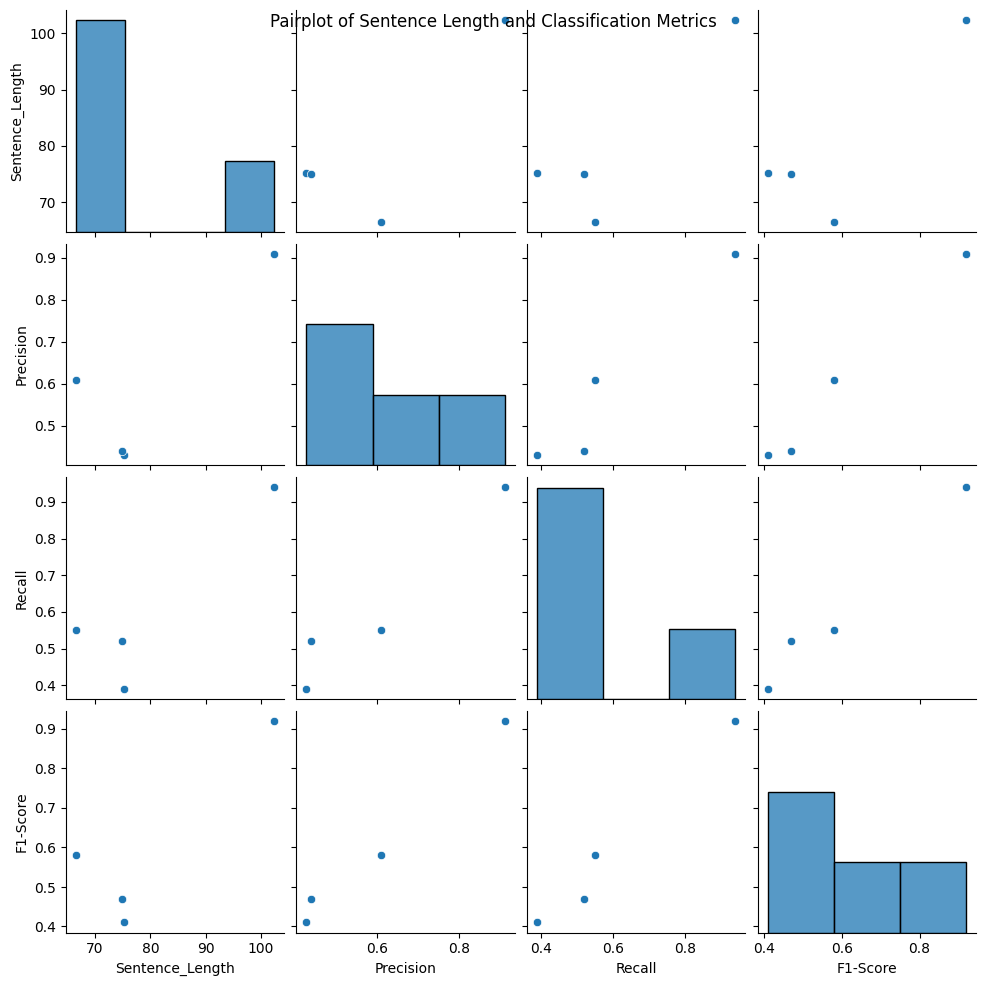

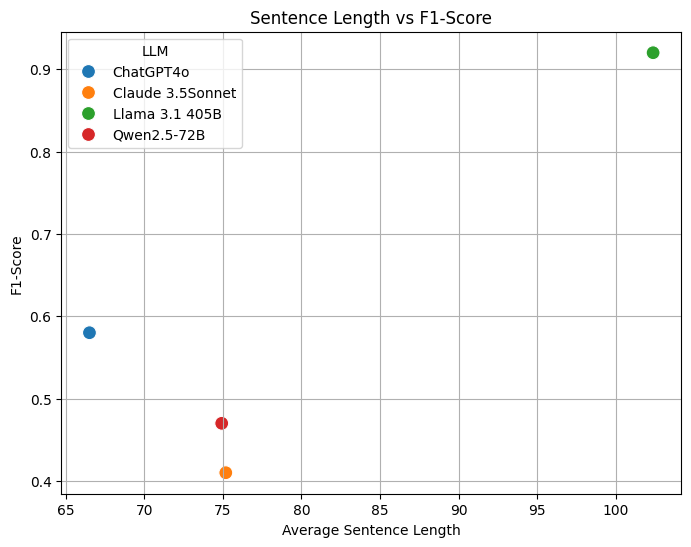

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the Excel data
file_path = '/short_sentence.xlsx'
data = pd.read_excel(file_path)

# Prepare the dataset
llm_columns = ['ChatGPT4o', 'Claude 3.5Sonnet', 'Llama 3.1 405B', 'Qwen2.5-72B']
data_long_format = pd.melt(data, id_vars=['Sentence'], value_vars=llm_columns, var_name='LLM', value_name='Expanded_Sentence')

# Calculate the length of each sentence
data_long_format['Sentence_Length'] = data_long_format['Expanded_Sentence'].apply(len)

# Calculate average sentence length for each LLM
average_length_per_llm = data_long_format.groupby('LLM')['Sentence_Length'].mean().reset_index()

# Create a DataFrame for classification metrics
metrics = {
    'LLM': ['ChatGPT4o', 'Claude 3.5Sonnet', 'Llama 3.1 405B', 'Qwen2.5-72B'],
    'Precision': [0.61, 0.43, 0.91, 0.44],
    'Recall': [0.55, 0.39, 0.94, 0.52],
    'F1-Score': [0.58, 0.41, 0.92, 0.47],
    'Support': [65, 67, 64, 64]
}

metrics_df = pd.DataFrame(metrics)

# Merge average length with classification metrics
merged_df = pd.merge(average_length_per_llm, metrics_df, on='LLM')

# Display the merged DataFrame
print("Merged DataFrame with Average Length and Classification Metrics:")
print(merged_df)

# Calculate the correlation between sentence length and classification metrics
correlation_matrix = merged_df[['Sentence_Length', 'Precision', 'Recall', 'F1-Score']].corr()

# Display the correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Plot correlations using pairplot
sns.pairplot(merged_df[['Sentence_Length', 'Precision', 'Recall', 'F1-Score']])
plt.suptitle('Pairplot of Sentence Length and Classification Metrics')
plt.show()

# Scatter plot for Sentence Length vs F1-Score
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='Sentence_Length', y='F1-Score', hue='LLM', s=100)
plt.title('Sentence Length vs F1-Score')
plt.xlabel('Average Sentence Length')
plt.ylabel('F1-Score')
plt.legend(title='LLM')
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch [5/50], Training Loss: 1.0096, Validation Loss: 1.0357
Epoch [10/50], Training Loss: 0.9201, Validation Loss: 1.0290
Epoch [15/50], Training Loss: 0.8690, Validation Loss: 1.0461
Epoch [20/50], Training Loss: 0.8222, Validation Loss: 1.0358
Epoch [25/50], Training Loss: 0.7757, Validation Loss: 1.0390
Epoch [30/50], Training Loss: 0.7264, Validation Loss: 1.0659
Epoch [35/50], Training Loss: 0.7047, Validation Loss: 1.0986
Epoch [40/50], Training Loss: 0.6629, Validation Loss: 1.1136
Epoch [45/50], Training Loss: 0.6138, Validation Loss: 1.1639
Epoch [50/50], Training Loss: 0.5801, Validation Loss: 1.1859


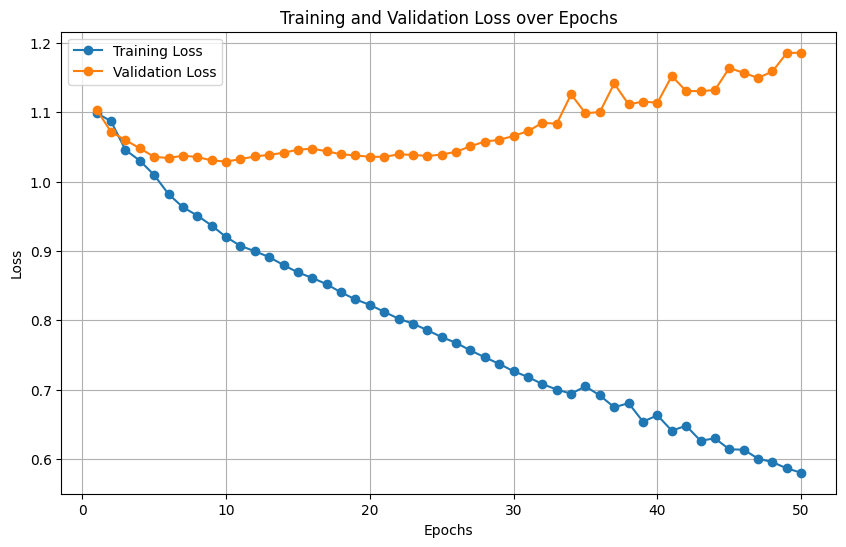

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel data
file_path = '/short_sentence.xlsx'
data = pd.read_excel(file_path)

# Prepare the dataset
llm_columns = ['ChatGPT4o', 'Claude 3.5Sonnet', 'Qwen2.5-72B']
data_long_format = pd.melt(data, id_vars=['Sentence'], value_vars=llm_columns, var_name='LLM', value_name='Expanded_Sentence')

# Define feature and target variables
X = data_long_format['Expanded_Sentence']
y = data_long_format['LLM']

# Encode the LLM labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Choose the model (using BERT in this example)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to generate embeddings using BERT
def generate_embeddings(text_list, tokenizer, model):
    embeddings = []
    for text in text_list:
        # Tokenize and get tensor input
        inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)

        # Use the [CLS] token embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)
    return torch.tensor(embeddings)

# Generate embeddings for training and testing datasets
X_train_embeddings = generate_embeddings(X_train.tolist(), tokenizer, model)
X_test_embeddings = generate_embeddings(X_test.tolist(), tokenizer, model)

# Define the RNN-based classification model
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = X_train_embeddings.shape[1]
hidden_size = 128
num_layers = 2
num_classes = len(label_encoder.classes_)

# Initialize the model, loss function, and optimizer
rnn_model = RNNClassifier(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Reshape embeddings to fit RNN input (batch_size, seq_length, input_size)
X_train_embeddings = X_train_embeddings.unsqueeze(1)
X_test_embeddings = X_test_embeddings.unsqueeze(1)

# Convert data to PyTorch tensors
X_train_tensor = X_train_embeddings.float()
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = X_test_embeddings.float()
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Training the model with loss tracking
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    rnn_model.train()
    optimizer.zero_grad()

    # Forward pass for training data
    train_outputs = rnn_model(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    # Store training loss
    train_losses.append(train_loss.item())

    # Validation phase
    rnn_model.eval()
    with torch.no_grad():
        val_outputs = rnn_model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())

    # Print loss every 5 epochs
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()


Test Accuracy: 0.4564
Classification Report:
                   precision    recall  f1-score   support

       ChatGPT4o       0.54      0.60      0.57        60
Claude 3.5Sonnet       0.40      0.30      0.34        70
     Qwen2.5-72B       0.43      0.49      0.46        65

        accuracy                           0.46       195
       macro avg       0.45      0.46      0.46       195
    weighted avg       0.45      0.46      0.45       195



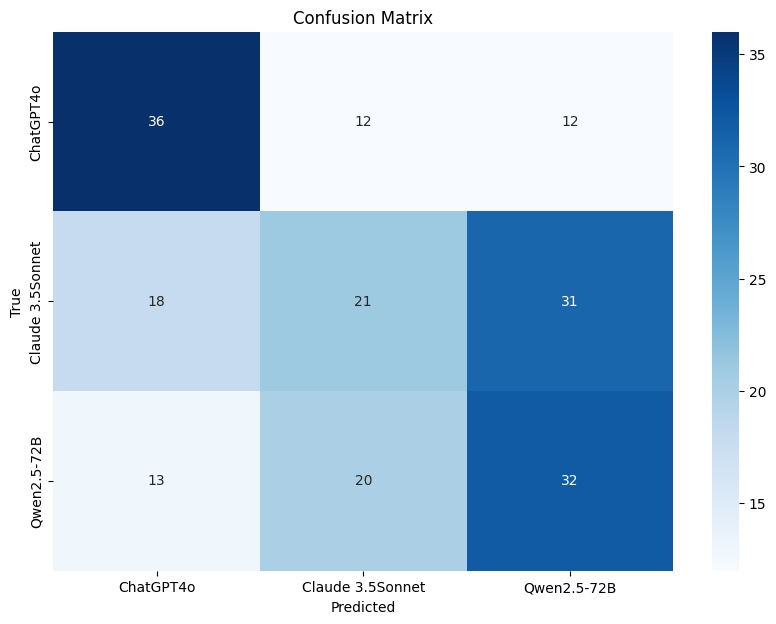

In [ ]:
# Evaluation
rnn_model.eval()
with torch.no_grad():
    # Predict on the test set
    outputs = rnn_model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

    # Calculate accuracy
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Test Accuracy: {accuracy:.4f}')

    # Generate classification report
    report = classification_report(y_test_tensor, predicted, target_names=label_encoder.classes_)
    print("Classification Report:\n", report)

    # Generate confusion matrix
    cm2 = confusion_matrix(y_test_tensor, predicted)
plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
